In [1]:
"""
    Get cleaned data
"""

import numpy as np

dataset = np.load('./datasets/PSD_per_Hz.npy')
labels = np.load('./datasets/labels.npy')
print(dataset.shape)
print(labels.shape)

(889, 4, 49)
(889,)


In [2]:
"""
    Split dataset
"""

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

flatten_dataset = dataset.reshape(dataset.shape[0], -1, 1)
shuf_dataset, shuf_labels = shuffle(flatten_dataset, labels)
X_train, X_test, y_train, y_test = train_test_split(shuf_dataset, shuf_labels, test_size=0.3)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)
print("Train set size: {}, Val set size: {}, Test set size: {}".format(len(X_train), len(X_val), len(X_test)))
print(y_train.shape)
print(X_train.shape)

Train set size: 622, Val set size: 134, Test set size: 133
(622,)
(622, 196, 1)


In [3]:
"""
    Model and train
"""

import keras
from keras.models import Sequential
from keras.layers import Convolution1D, MaxPool1D, GlobalMaxPool1D
from keras.layers import Activation, Dense, Dropout, SpatialDropout1D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

model_path = './models/'
json_name = 'CNN_PSD.json'
weight_name = 'CNN_PSD_tmp.h5'

batch_size = 16
epochs = 128
num_classes = 2

print("Constructing MLP Model: ...", end='')
model = Sequential()
model.add(Convolution1D(16, kernel_size=4, padding='valid', input_shape= X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Convolution1D(16, kernel_size=4, padding='valid'))
model.add(Activation('relu'))
model.add(MaxPool1D(pool_size=2))
model.add(SpatialDropout1D(rate=0.01))

model.add(Convolution1D(32, kernel_size=3, padding='valid'))
model.add(Activation('relu'))
model.add(Convolution1D(32, kernel_size=3, padding='valid'))
model.add(Activation('relu'))
model.add(MaxPool1D(pool_size=2))
model.add(SpatialDropout1D(rate=0.01))

model.add(Convolution1D(64, kernel_size=3, padding='valid'))
model.add(Activation('relu'))
model.add(Convolution1D(64, kernel_size=3, padding='valid'))
model.add(Activation('relu'))
model.add(GlobalMaxPool1D())
model.add(Dropout(rate=0.01))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.02))
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.05))
model.add(Dense(1))
model.add(Activation('sigmoid'))
print(" Complete.")

print("Compiling MLP Model: ...", end='')
optimizer = Adam(lr=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
print(" Complete.")

earlyStop = EarlyStopping(monitor='val_loss', patience=32, mode='min')
mcp_save = ModelCheckpoint(filepath=model_path+weight_name, save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, min_delta=1e-4, mode='min')

print("Fitting MLP Model: ...")
results = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[earlyStop, mcp_save, reduce_lr_loss], validation_data=(X_val, y_val), shuffle=True)
print("Complete.")

Using TensorFlow backend.


Constructing MLP Model: ... Complete.
Compiling MLP Model: ... Complete.
Fitting MLP Model: ...
Train on 622 samples, validate on 134 samples
Epoch 1/128
622/622 [==============================] - 2s 3ms/step - loss: 0.6862 - acc: 0.5691 - val_loss: 0.6458 - val_acc: 0.7463
Epoch 2/128
622/622 [==============================] - 1s 1ms/step - loss: 0.6317 - acc: 0.7331 - val_loss: 0.5961 - val_acc: 0.7761
Epoch 3/128
622/622 [==============================] - 1s 1ms/step - loss: 0.5918 - acc: 0.7170 - val_loss: 0.5482 - val_acc: 0.8134
Epoch 4/128
622/622 [==============================] - 1s 1ms/step - loss: 0.5415 - acc: 0.7476 - val_loss: 0.5089 - val_acc: 0.8060
Epoch 5/128
622/622 [==============================] - 1s 1ms/step - loss: 0.5141 - acc: 0.7605 - val_loss: 0.4849 - val_acc: 0.7910
Epoch 6/128
622/622 [==============================] - 1s 1ms/step - loss: 0.5083 - acc: 0.7637 - val_loss: 0.4689 - val_acc: 0.8060
Epoch 7/128
622/622 [==============================] - 1s 1m

In [4]:
"""
    Save the model
"""

model_path = './models/'
json_name = 'CNN_PSD.json'
weight_name = 'CNN_PSD.h5'

model_json = model.to_json()
with open(model_path+json_name, 'w') as json_file:
    json_file.write(model_json)
#model.save_weights(model_path+weight_name)

In [5]:
"""
    Output & plot the results
    Aspect Ratio 2 to 1
"""

import matplotlib.pyplot as plt

image_path = './graphs/'
image_name = 'CNN_PSD_2to1.png'

fig = plt.figure(figsize=(10,5))
plt.plot(results.history['loss'], label='train loss')
plt.plot(results.history['val_loss'], label='val loss')
plt.plot(results.history['acc'], label='train acc')
plt.plot(results.history['val_acc'], label='val acc')
plt.ylim((0.05,1.1))
plt.legend(loc='lower left')
plt.title('Power Spectral Density [1-50 Hz] CNN')
plt.xlabel('Epoch(s)')
plt.ylabel('Performance')
#plt.show()
plt.savefig(image_path+image_name, bbox_inches='tight')
test_scores = model.evaluate(X_test, y_test)
print("\nFinal test %s: %.2f%%" % (model.metrics_names[1], test_scores[1]*100))

133/133 [==============================] - 0s 270us/step

Final test acc: 87.22%


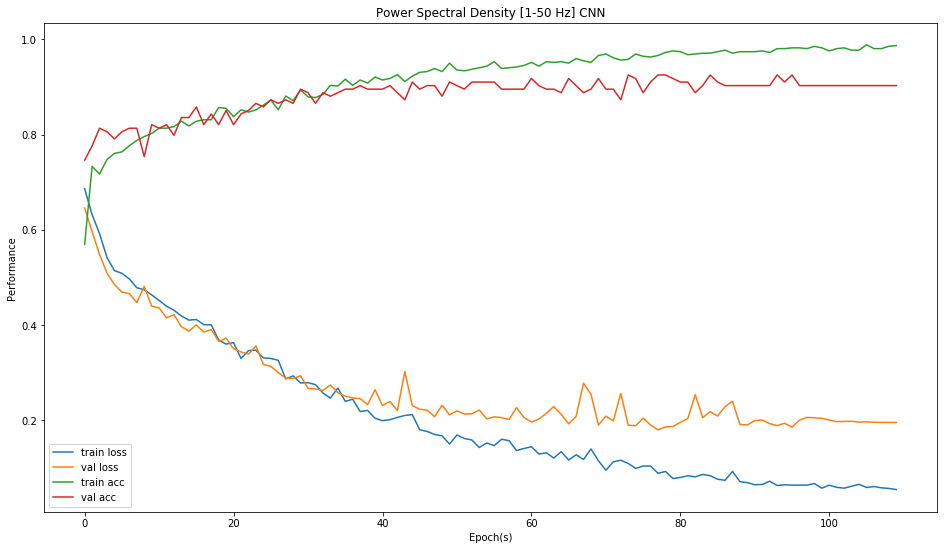

In [6]:
"""
    Output & plot the results
    Aspect Ratio 2 to 1
"""

import matplotlib.pyplot as plt

image_path = './graphs/'
image_name = 'CNN_PSD_16to9.png'

fig = plt.figure(figsize=(16,9))
plt.plot(results.history['loss'], label='train loss')
plt.plot(results.history['val_loss'], label='val loss')
plt.plot(results.history['acc'], label='train acc')
plt.plot(results.history['val_acc'], label='val acc')
plt.legend(loc='lower left')
plt.title('Power Spectral Density [1-50 Hz] CNN')
plt.xlabel('Epoch(s)')
plt.ylabel('Performance')
#plt.show()
plt.savefig(image_path+image_name, bbox_inches='tight')

In [8]:
"""
    Try fetching the model
"""

from keras.models import model_from_json

model_path = './models/'
json_name = 'CNN_PSD.json'
weight_name = 'CNN_PSD.h5'

json_file = open(model_path+json_name)
loaded_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_json)
loaded_model.load_weights(model_path+weight_name)
loaded_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

loaded_test_score = model.evaluate(X_test, y_test)
print("\nFinal test %s: %.2f%%" % (loaded_model.metrics_names[1], loaded_test_score[1]*100))

133/133 [==============================] - 0s 2ms/step

Final test acc: 87.22%
